In [1]:
%reload_kedro

2023-03-15 15:06:03,117 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/guilhermepalazzo/Desktop/dev/git_repositories/crypto_msc_thesis
2023-03-15 15:06:03,937 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-03-15 15:06:04,181 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-03-15 15:06:04,183 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [21]:
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from numpy import array #useful to parse values

In [22]:
plt.style.use("grayscale")
warnings.filterwarnings("ignore")

### XGBoost

In [23]:
model = catalog.load("xgboost_fitted_model")
X_test = catalog.load("xgboost_features_test")
y_test = catalog.load("xgboost_target_test")
y_pred = catalog.load("xgboost_model_predict")

df_model_rpt = catalog.load("xgboost_model_reporting")

2023-03-15 15:08:50,891 - kedro.io.data_catalog - INFO - Loading data from `xgboost_fitted_model` (PickleDataSet)...
2023-03-15 15:08:50,946 - kedro.io.data_catalog - INFO - Loading data from `xgboost_features_test` (ParquetDataSet)...
2023-03-15 15:08:51,011 - kedro.io.data_catalog - INFO - Loading data from `xgboost_target_test` (ParquetDataSet)...
2023-03-15 15:08:51,029 - kedro.io.data_catalog - INFO - Loading data from `xgboost_model_predict` (ParquetDataSet)...
2023-03-15 15:08:51,045 - kedro.io.data_catalog - INFO - Loading data from `xgboost_model_reporting` (ParquetDataSet)...


In [5]:
_roc_auc_score = roc_auc_score(y_true=y_test, y_score=y_pred)
_roc_auc_score

0.6657070707070707

In [6]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.69      0.81      0.75       396
           1       0.67      0.52      0.59       300

    accuracy                           0.69       696
   macro avg       0.68      0.67      0.67       696
weighted avg       0.68      0.69      0.68       696



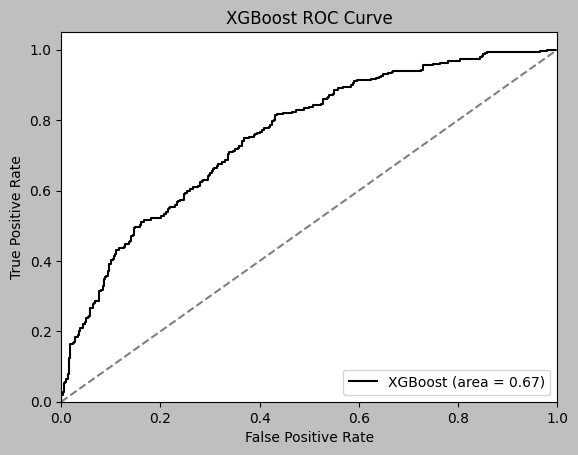

In [7]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

plt.figure()

plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % _roc_auc_score)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('XGBoost ROC Curve')
plt.legend(loc="lower right")

plt.savefig("/Users/guilhermepalazzo/Desktop/fig_xgboost_roc_curve.png")

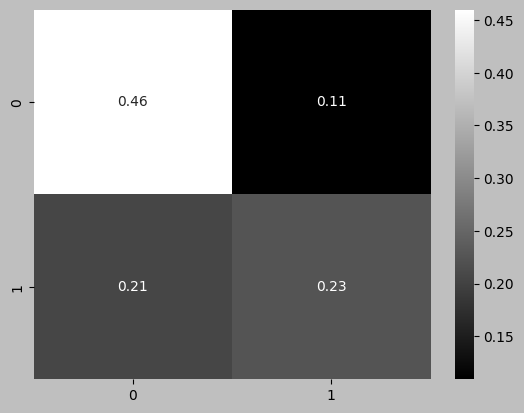

In [24]:
cm = eval(df_model_rpt["confusion_matrix"][0])

plot = sns.heatmap(cm, annot=True, cmap="gray")

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_xgboost_cm.png")

### LSTM

In [25]:
from crypto_thesis.data_domains.modeling.lstm import _build_lstm_timestamps_seq

In [26]:
y_test = catalog.load("lstm_target_test")
y_pred = catalog.load("lstm_model_predict")
X_test = catalog.load("lstm_features_test")

model = catalog.load("lstm_fitted_model")

seq_length = catalog.load("params:lstm_timestamp_seq_length")

df_model_rpt = catalog.load("lstm_model_reporting")

2023-03-15 15:11:05,280 - kedro.io.data_catalog - INFO - Loading data from `lstm_target_test` (ParquetDataSet)...
2023-03-15 15:11:05,292 - kedro.io.data_catalog - INFO - Loading data from `lstm_model_predict` (ParquetDataSet)...
2023-03-15 15:11:05,301 - kedro.io.data_catalog - INFO - Loading data from `lstm_features_test` (ParquetDataSet)...
2023-03-15 15:11:05,338 - kedro.io.data_catalog - INFO - Loading data from `lstm_fitted_model` (TensorFlowModelDataset)...
2023-03-15 15:11:08,866 - kedro.io.data_catalog - INFO - Loading data from `params:lstm_timestamp_seq_length` (MemoryDataSet)...
2023-03-15 15:11:08,867 - kedro.io.data_catalog - INFO - Loading data from `lstm_model_reporting` (ParquetDataSet)...


In [27]:
_roc_auc_score = roc_auc_score(y_true=y_test, y_score=y_pred)
_roc_auc_score

0.502906976744186

In [28]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67       352
           1       1.00      0.01      0.01       344

    accuracy                           0.51       696
   macro avg       0.75      0.50      0.34       696
weighted avg       0.75      0.51      0.35       696



In [29]:
X_test, _ = _build_lstm_timestamps_seq(X=X_test, y=y_test, seq_length=seq_length)
M_TEST = X_test.shape[0]

predict_probas = model.predict(x=X_test, batch_size=M_TEST, verbose=1)

1/1 [==============================] - 1s 734ms/step


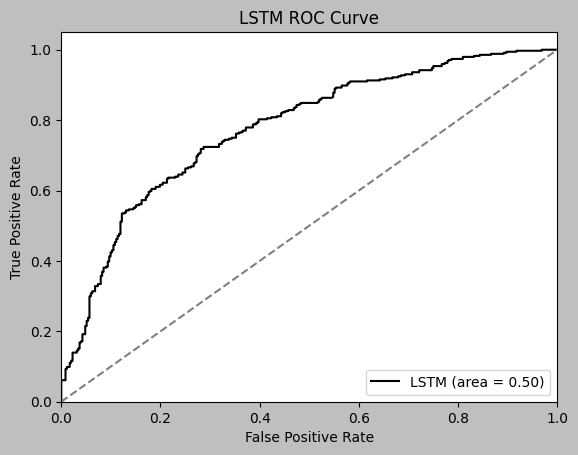

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, predict_probas.ravel())

plt.figure()
plt.plot(fpr, tpr, label='LSTM (area = %0.2f)' % _roc_auc_score)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('LSTM ROC Curve')
plt.legend(loc="lower right")

plt.savefig("/Users/guilhermepalazzo/Desktop/fig_lstm_roc_curve.png")

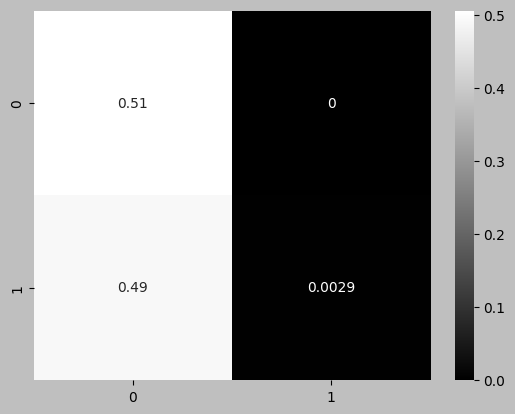

In [31]:
cm = eval(df_model_rpt["confusion_matrix"][0])

plot = sns.heatmap(cm, annot=True, cmap="gray")

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_lstm_cm.png")

### LogReg

In [32]:
model = catalog.load("logreg_fitted_model")
X_test = catalog.load("logreg_features_test")
y_test = catalog.load("logreg_target_test")
y_pred = catalog.load("logreg_model_predict")

df_model_rpt = catalog.load("logreg_model_reporting")

2023-03-15 15:12:07,922 - kedro.io.data_catalog - INFO - Loading data from `logreg_fitted_model` (PickleDataSet)...
2023-03-15 15:12:07,928 - kedro.io.data_catalog - INFO - Loading data from `logreg_features_test` (ParquetDataSet)...
2023-03-15 15:12:07,943 - kedro.io.data_catalog - INFO - Loading data from `logreg_target_test` (ParquetDataSet)...
2023-03-15 15:12:07,950 - kedro.io.data_catalog - INFO - Loading data from `logreg_model_predict` (ParquetDataSet)...
2023-03-15 15:12:07,958 - kedro.io.data_catalog - INFO - Loading data from `logreg_model_reporting` (ParquetDataSet)...


In [33]:
_roc_auc_score = roc_auc_score(y_true=y_test, y_score=y_pred)
_roc_auc_score

0.4984848484848485

In [34]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       345
           1       0.49      1.00      0.66       330

    accuracy                           0.49       675
   macro avg       0.24      0.50      0.33       675
weighted avg       0.24      0.49      0.32       675



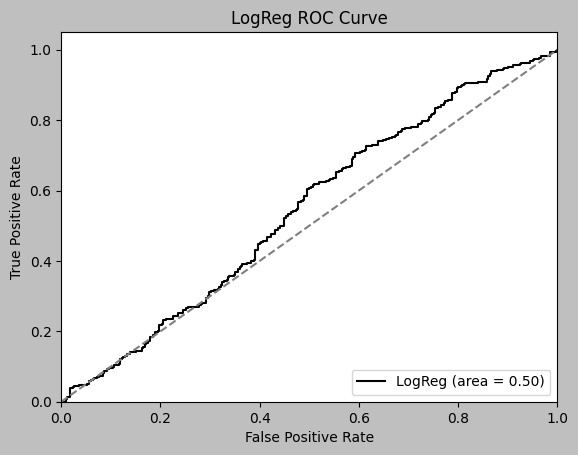

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='LogReg (area = %0.2f)' % _roc_auc_score)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('LogReg ROC Curve')
plt.legend(loc="lower right")

plt.savefig("/Users/guilhermepalazzo/Desktop/fig_logreg_roc_curve.png")

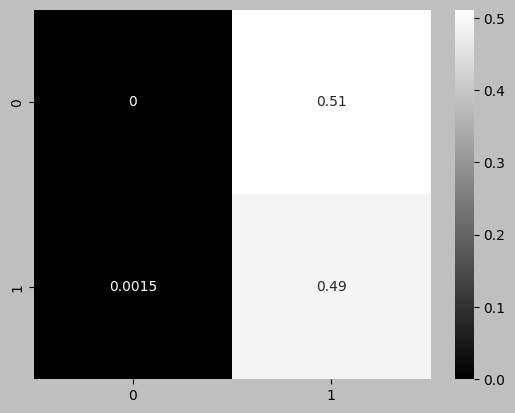

In [36]:
cm = eval(df_model_rpt["confusion_matrix"][0])

plot = sns.heatmap(cm, annot=True, cmap="gray")

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_logreg_cm.png")